In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

In [2]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)  # ulaz
        for i in range(len(self.layers) - 1):
            X = self.activation(self.layers[i](X))
        return self.layers[-1](X)  # izlaz

def burgers_residual(model, x, t, nu=0.01/torch.pi):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx
    return f

def pinn_loss(model, x_f, t_f, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc):
    f_pred = burgers_residual(model, x_f, t_f)
    loss_f = torch.mean(f_pred**2)

    u_pred_ic = model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    u_pred_bc = model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_f + loss_ic + loss_bc

In [4]:
model = PINN(layers=[2, 50, 50, 50, 1])  # (x,t) 2 >>> u 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
N_f = 10000
N_ic = 200
N_bc = 200

x_f = torch.rand((N_f,1)) * 2 - 1
t_f = torch.rand((N_f,1))

x_ic = torch.linspace(-1, 1, N_ic).view(-1,1)
t_ic = torch.zeros_like(x_ic)
u_ic = -torch.sin(np.pi * x_ic)

t_bc = torch.rand((N_bc,1))
x_bc_left = -torch.ones_like(t_bc)
x_bc_right = torch.ones_like(t_bc)
u_bc = torch.zeros_like(t_bc)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    loss_left = pinn_loss(model, x_f, t_f, x_ic, t_ic, u_ic, x_bc_left, t_bc, u_bc)
    
    loss_right = pinn_loss(model, x_f, t_f, x_ic, t_ic, u_ic, x_bc_right, t_bc, u_bc)
    
    loss = 0.5 * (loss_left + loss_right)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")

Epoch 0, Loss = 5.0164e-01
Epoch 1000, Loss = 8.6490e-02
Epoch 2000, Loss = 4.3368e-02
Epoch 3000, Loss = 1.8067e-02
Epoch 4000, Loss = 1.0947e-02


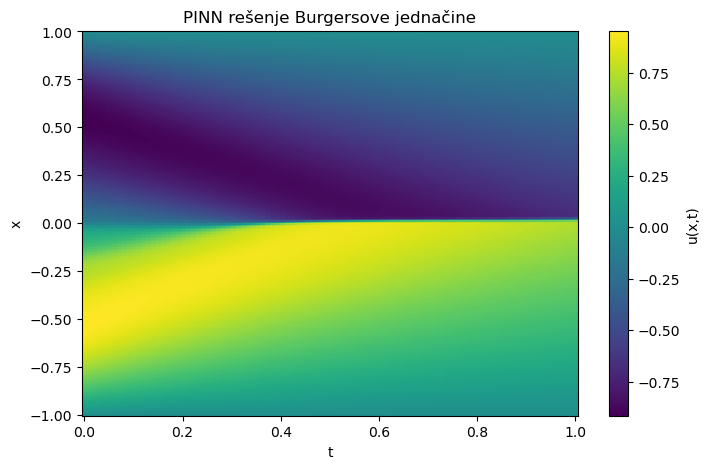

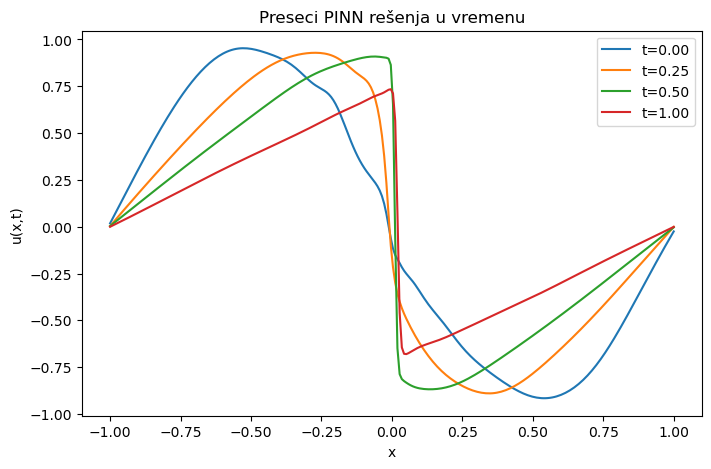

In [6]:
x = torch.linspace(-1, 1, 256)
t = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x, t, indexing='ij')

x_eval = X.reshape(-1,1)
t_eval = T.reshape(-1,1)

with torch.no_grad():
    u_pred = model(x_eval, t_eval).reshape(X.shape)

u_pred = u_pred.cpu().numpy()
Xn, Tn = X.cpu().numpy(), T.cpu().numpy()

plt.figure(figsize=(8,5))
plt.pcolormesh(Tn, Xn, u_pred, shading='auto')
plt.colorbar(label="u(x,t)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("PINN rešenje Burgersove jednačine")
plt.show()

plt.figure(figsize=(8,5))
for tau in [0.0, 0.25, 0.5, 1.0]:
    t_slice = torch.full_like(x, tau).view(-1,1)
    with torch.no_grad():
        u_slice = model(x.view(-1,1), t_slice).squeeze().cpu().numpy()
    plt.plot(x.numpy(), u_slice, label=f"t={tau:.2f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Preseci PINN rešenja u vremenu")
plt.show()

In [7]:
def load_burgers_data(mat_file="burgers_data.mat", scheme="exp"):
    data = scipy.io.loadmat(mat_file)

    x = data["x"].squeeze()
    if scheme == "exp":
        u = data["u_exp"]
        t = data["t_exp"].squeeze()
    elif scheme == "imp":
        u = data["u_imp"]
        t = data["t_imp"].squeeze()
    else:
        raise ValueError("scheme mora biti 'exp' ili 'imp'")

    X, T = np.meshgrid(x, t, indexing="ij")

    inputs = np.stack([X.flatten(), T.flatten()], axis=1)
    outputs = u.flatten()[:, None]

    return inputs, outputs, x, t, u

In [8]:
inputs_exp, outputs_exp, x_exp, t_exp, u_exp = load_burgers_data("/Users/aleksamilovanovic/Desktop/diplomski/eksperimenti/burgers_data.mat", scheme="exp")
inputs_imp, outputs_imp, x_imp, t_imp, u_imp = load_burgers_data("/Users/aleksamilovanovic/Desktop/diplomski/eksperimenti/burgers_data.mat", scheme="imp")

In [9]:
X_train_exp, X_val_exp, y_train_exp, y_val_exp = train_test_split(
    inputs_exp, outputs_exp, test_size=0.2, random_state=42
)

X_train_imp, X_val_imp, y_train_imp, y_val_imp = train_test_split(
    inputs_imp, outputs_imp, test_size=0.2, random_state=42
)

X_train_exp = torch.tensor(X_train_exp, dtype=torch.float32)
y_train_exp = torch.tensor(y_train_exp, dtype=torch.float32)
X_val_exp = torch.tensor(X_val_exp, dtype=torch.float32)
y_val_exp = torch.tensor(y_val_exp, dtype=torch.float32)

X_train_imp = torch.tensor(X_train_imp, dtype=torch.float32)
y_train_imp = torch.tensor(y_train_imp, dtype=torch.float32)
X_val_imp = torch.tensor(X_val_imp, dtype=torch.float32)
y_val_imp = torch.tensor(y_val_imp, dtype=torch.float32)

In [10]:
class MLP(nn.Module):
    def __init__(self, layers=[2,50,50,50,1]):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)
    
model_exp = MLP()
optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [11]:
epochs = 5000

for epoch in range(epochs):
    model_exp.train()
    optimizer_exp.zero_grad()
    y_pred = model_exp(X_train_exp)
    loss = criterion(y_pred, y_train_exp)
    loss.backward()
    optimizer_exp.step()

    if epoch % 500 == 0:
        model_exp.eval()
        val_pred = model_exp(X_val_exp)
        val_loss = criterion(val_pred, y_val_exp)
        print(f"Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

Epoch 0, Train Loss: 0.286027, Val Loss: 0.247703
Epoch 500, Train Loss: 0.013220, Val Loss: 0.011704
Epoch 1000, Train Loss: 0.003261, Val Loss: 0.002801
Epoch 1500, Train Loss: 0.001229, Val Loss: 0.001224
Epoch 2000, Train Loss: 0.000599, Val Loss: 0.000644
Epoch 2500, Train Loss: 0.000346, Val Loss: 0.000376
Epoch 3000, Train Loss: 0.000207, Val Loss: 0.000232
Epoch 3500, Train Loss: 0.000131, Val Loss: 0.000151
Epoch 4000, Train Loss: 0.000088, Val Loss: 0.000106
Epoch 4500, Train Loss: 0.000061, Val Loss: 0.000077


In [12]:
model_exp.eval()
with torch.no_grad():
    val_pred = model_exp(X_val_exp)
    val_mse = criterion(val_pred, y_val_exp).item()
    val_rmse = np.sqrt(val_mse)
    print(f"Final Validation MSE: {val_mse:.6e}, RMSE: {val_rmse:.6e}")

Final Validation MSE: 5.808350e-05, RMSE: 7.621253e-03


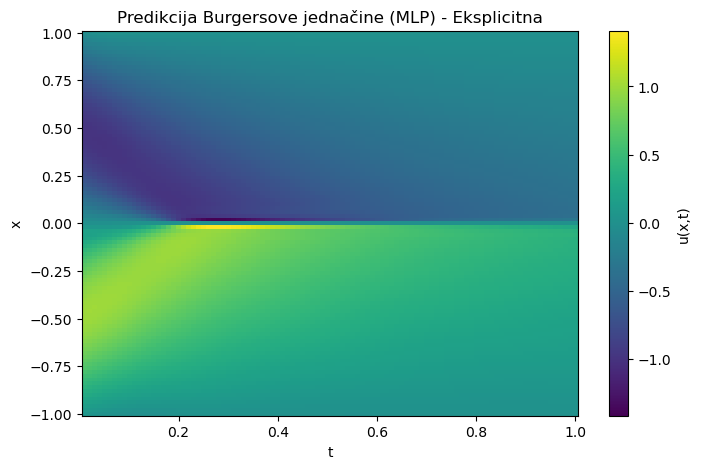

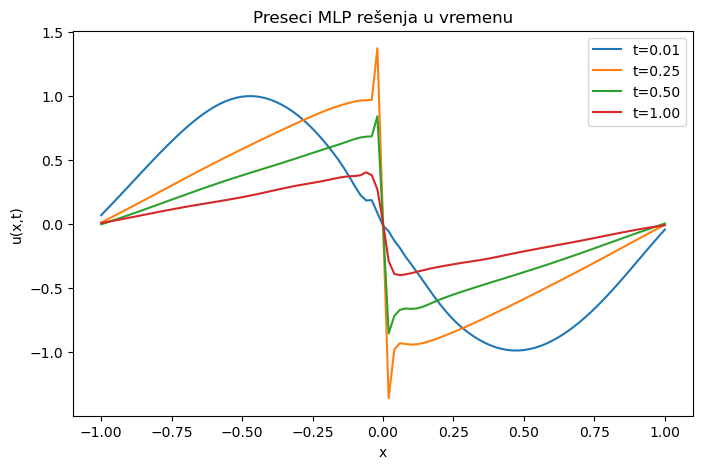

In [13]:
X_grid = torch.tensor(inputs_exp, dtype=torch.float32)

with torch.no_grad():
    u_pred = model_exp(X_grid).cpu().numpy()

Nx = x_exp.shape[0]
Nt_s = len(t_exp)
u_pred_grid = u_pred.reshape((Nx, Nt_s))

plt.figure(figsize=(8,5))
plt.pcolormesh(t_exp, x_exp, u_pred_grid, shading='auto')
plt.colorbar(label="u(x,t)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predikcija Burgersove jednačine (MLP) - Eksplicitna")
plt.show()

plt.figure(figsize=(8,5))

for t in [0.0, 0.25, 0.5, 1.0]:
    idx = np.argmin(np.abs(t_exp - t))
    u_slice = u_pred_grid[:, idx]
    plt.plot(x_exp, u_slice, label=f"t={t_exp[idx]:.2f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Preseci MLP rešenja u vremenu")
plt.show()

In [14]:
model_imp = MLP()
optimizer_imp = torch.optim.Adam(model_imp.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 5000

for epoch in range(epochs):
    model_imp.train()
    optimizer_exp.zero_grad()
    y_pred = model_imp(X_train_imp)
    loss = criterion(y_pred, y_train_imp)
    loss.backward()
    optimizer_exp.step()

    if epoch % 500 == 0:
        model_imp.eval()
        val_pred = model_exp(X_val_imp)
        val_loss = criterion(val_pred, y_val_imp)
        print(f"Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

Epoch 0, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 500, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 1000, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 1500, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 2000, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 2500, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 3000, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 3500, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 4000, Train Loss: 0.229752, Val Loss: 0.000057
Epoch 4500, Train Loss: 0.229752, Val Loss: 0.000057


Final Validation MSE: 5.808350e-05, RMSE: 7.621253e-03


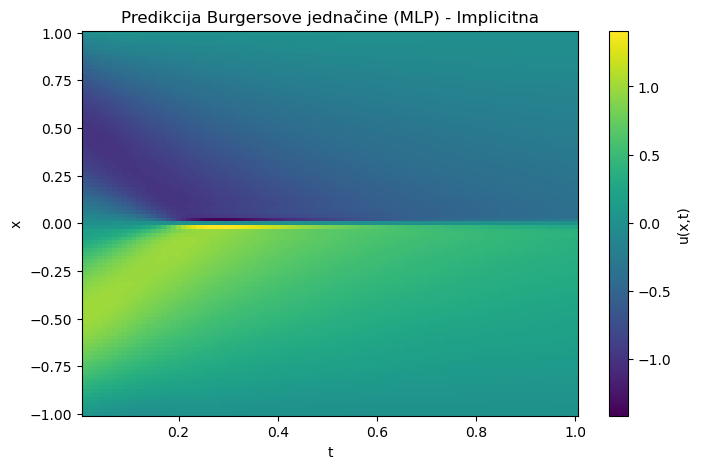

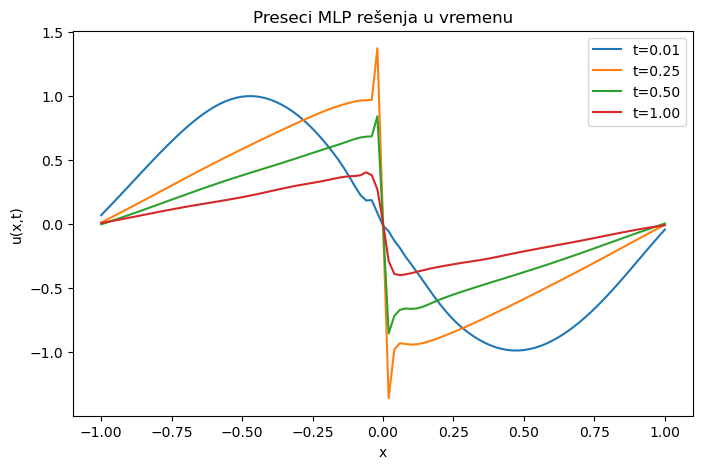

In [17]:
model_exp.eval()
with torch.no_grad():
    val_pred = model_exp(X_val_exp)
    val_mse = criterion(val_pred, y_val_exp).item()
    val_rmse = np.sqrt(val_mse)
    print(f"Final Validation MSE: {val_mse:.6e}, RMSE: {val_rmse:.6e}")
    
X_grid = torch.tensor(inputs_exp, dtype=torch.float32)

with torch.no_grad():
    u_pred = model_exp(X_grid).cpu().numpy()

Nx = x_exp.shape[0]
Nt_s = len(t_exp)
u_pred_grid = u_pred.reshape((Nx, Nt_s))

plt.figure(figsize=(8,5))
plt.pcolormesh(t_imp, x_imp, u_pred_grid, shading='auto')
plt.colorbar(label="u(x,t)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Predikcija Burgersove jednačine (MLP) - Implicitna")
plt.show()

plt.figure(figsize=(8,5))

for t in [0.0, 0.25, 0.5, 1.0]:
    idx = np.argmin(np.abs(t_imp - t))
    u_slice = u_pred_grid[:, idx]
    plt.plot(x_imp, u_slice, label=f"t={t_imp[idx]:.2f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Preseci MLP rešenja u vremenu")
plt.show()